#Bankruptcy-Prediction-in-Taiwan
________________
By Ahmed Ali



##Environment set-up

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score,ConfusionMatrixDisplay,confusion_matrix,classification_report
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingClassifier
from ipywidgets import widget
from ipywidgets import interact
import pickle
from sklearn.pipeline import make_pipeline

##Prepare Data

###Import

In [2]:
df=pd.read_csv("/content/data .csv")
print(df.shape)
df.index.name ='id'
df

(6819, 96)


,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
id,,,,,,,,,,,,,,,,,,,,,
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6814,0,0.493687,0.539468,0.543230,0.604455,0.604462,0.998992,0.797409,0.809331,0.303510,...,0.799927,0.000466,0.623620,0.604455,0.840359,0.279606,0.027064,0.566193,1,0.029890
6815,0,0.475162,0.538269,0.524172,0.598308,0.598308,0.998992,0.797414,0.809327,0.303520,...,0.799748,0.001959,0.623931,0.598306,0.840306,0.278132,0.027009,0.566018,1,0.038284
6816,0,0.472725,0.533744,0.520638,0.610444,0.610213,0.998984,0.797401,0.809317,0.303512,...,0.797778,0.002840,0.624156,0.610441,0.840138,0.275789,0.026791,0.565158,1,0.097649


###Explore

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

####Handling Outliers and Multicollinearity
After confirming that there are no null values in the dataset, the next critical steps are to detect outliers and assess multicollinearity

In [63]:
df.rename(columns={'Bankrupt?': 'bankrupt'}, inplace=True)

Text(0.5, 1.0, 'Class Balance')

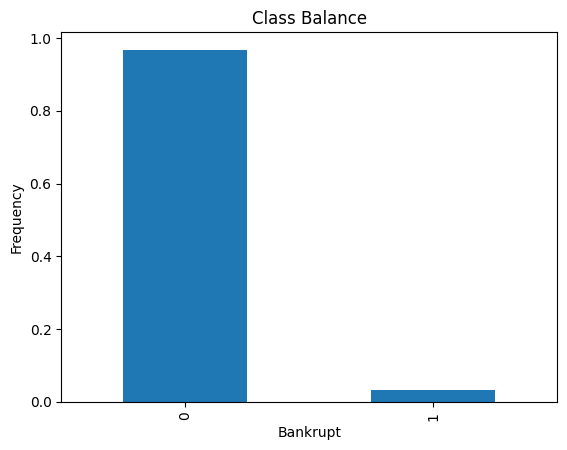

In [5]:
df['bankrupt'].value_counts(normalize=True).plot(kind="bar")
plt.xlabel("Bankrupt")
plt.ylabel("Frequency")
plt.title("Class Balance")

its shows us that we have an imbalanced dataset, where our majority class is far bigger than our minority class.

Text(0.5, 1.0, 'Distribution of ROA(A) before interest and % after tax, by Class')

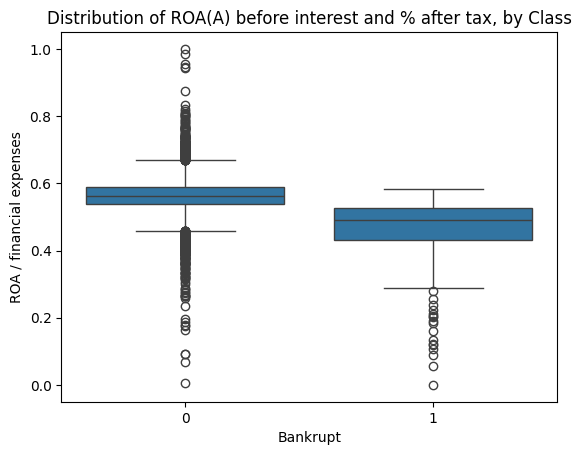

In [6]:
sns.boxplot(x='bankrupt', y=' ROA(A) before interest and % after tax',data=df)
plt.xlabel("Bankrupt")
plt.ylabel("ROA / financial expenses")
plt.title("Distribution of ROA(A) before interest and % after tax, by Class")

In [7]:
# Summary statistics for `feat_27`
df[' ROA(A) before interest and % after tax'].describe()

,ROA(A) before interest and % after tax
count,6819.000000
mean,0.558625
std,0.065620
min,0.000000
25%,0.535543
50%,0.559802
75%,0.589157
max,1.000000


<Axes: xlabel=' ROA(A) before interest and % after tax', ylabel='Count'>

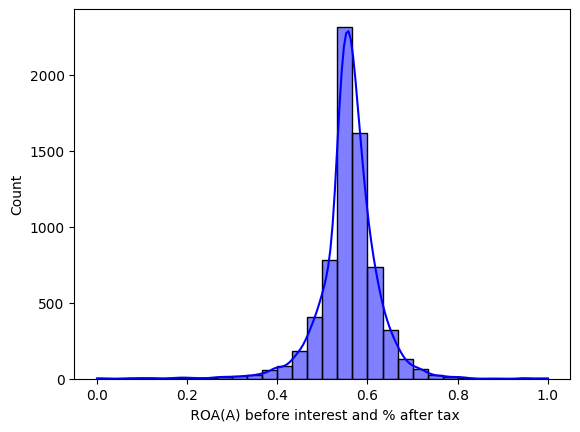

In [8]:
sns.histplot(df[' ROA(A) before interest and % after tax'], kde=True, color='blue', bins=30)

In [9]:
def Outliers(col, col_name, df):
    if pd.api.types.is_bool_dtype(col):
        print(f"Skipping column {col_name} because it is boolean.")
        return df
    if not pd.api.types.is_numeric_dtype(col):
        raise ValueError(f"The column '{col_name}' must be numeric.")
    print(col_name)
    q25, q75 = np.percentile(col, 25), np.percentile(col, 75)
    iqr = q75 - q25
    print(f"Q25 is {q25} and Q75 is {q75} | iqr is {iqr}")

    cutoff = iqr * 1.5
    lower_cutoff, upper_cutoff = q25 - cutoff, q75 + cutoff
    print(f"Cutoff is {cutoff} | Lower is {lower_cutoff} and Upper is {upper_cutoff}")

    outliers = [x for x in col if (x<lower_cutoff) or (x>upper_cutoff)]
    print(f"Number of outliers is {len(outliers)}")

#     df = df.drop(df[(df[col_name] > upper_cutoff) | (df[col_name] < lower_cutoff)].index)
#     print('-' * 50)

#     return df

In [10]:
 for col in df.columns:
   Outliers(df[col],str(col), df)

 ROA(C) before interest and depreciation before interest
Q25 is 0.476527080388047 and Q75 is 0.535562813825379 | iqr is 0.05903573343733198
Cutoff is 0.08855360015599797 | Lower is 0.38797348023204903 and Upper is 0.624116413981377
Number of outliers is 391
 ROA(A) before interest and % after tax
Q25 is 0.53554295682512 and Q75 is 0.58915721761884 | iqr is 0.05361426079372
Cutoff is 0.08042139119058 | Lower is 0.45512156563454 and Upper is 0.66957860880942
Number of outliers is 561
 ROA(B) before interest and depreciation after tax
Q25 is 0.527276620804112 and Q75 is 0.584105144815033 | iqr is 0.05682852401092098
Cutoff is 0.08524278601638147 | Lower is 0.4420338347877305 and Upper is 0.6693479308314144
Number of outliers is 432
 Operating Gross Margin
Q25 is 0.6004446590466855 and Q75 is 0.613914152697502 | iqr is 0.01346949365081651
Cutoff is 0.020204240476224766 | Lower is 0.5802404185704608 and Upper is 0.6341183931737269
Number of outliers is 320
 Realized Sales Gross Margin
Q25 i

<Axes: >

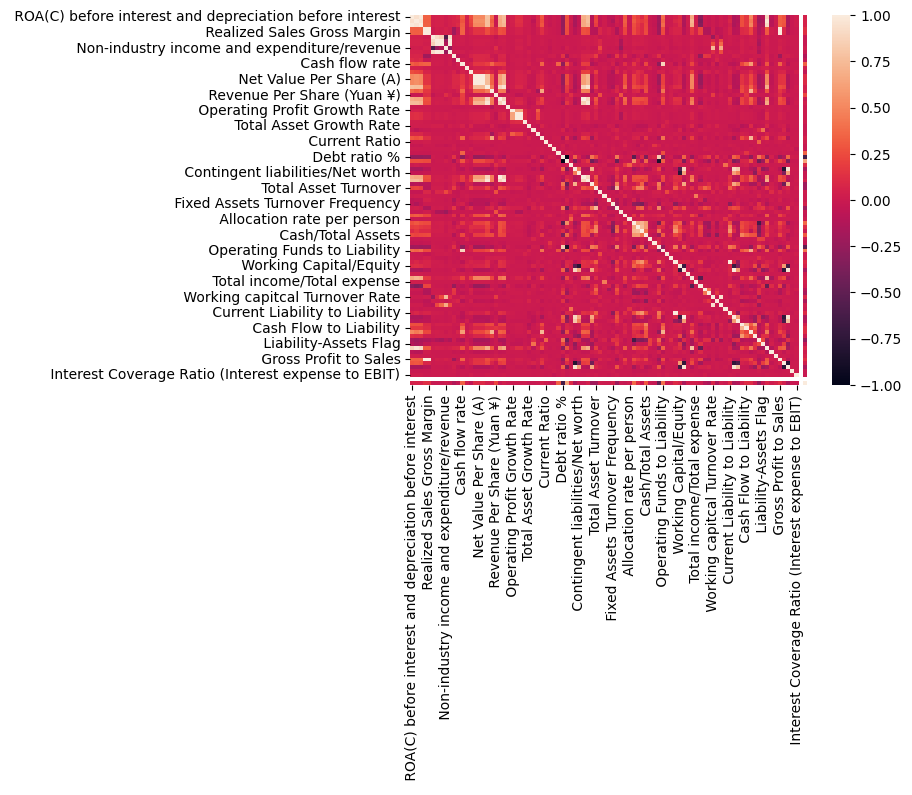

In [11]:
corr = df.drop(columns='bankrupt').corr()
sns.heatmap(corr)

In [12]:
df.shape

(6819, 96)

In [43]:
import pandas as pd

def detect_target_leakage(df, target_column, correlation_threshold=0.8):
    corr_matrix = df.corr()
    corr_target = corr_matrix[target_column].sort_values(ascending=False)
    print("Correlations with target column:/n", corr_target)

    leakage_features = corr_target[abs(corr_target) > correlation_threshold].index.tolist()
    leakage_features.remove(target_column)

    if leakage_features:
        print(f"Potential leakage detected from the following features: {leakage_features}")
    else:
        print("No potential leakage detected based on the specified correlation threshold.")

    print(leakage_features)

In [42]:
detect_target_leakage(df, 'bankrupt')

Correlations with target column:/n bankrupt                                                    1.000000
 Debt ratio %                                               0.250161
 Current Liability to Assets                                0.194494
 Borrowing dependency                                       0.176543
 Current Liability to Current Assets                        0.171306
                                                              ...   
 ROA(C) before interest and depreciation before interest   -0.260807
 ROA(B) before interest and depreciation after tax         -0.273051
 ROA(A) before interest and % after tax                    -0.282941
 Net Income to Total Assets                                -0.315457
 Net Income Flag                                                 NaN
Name: bankrupt, Length: 96, dtype: float64
No potential leakage detected based on the specified correlation threshold.


[]

We have autocorrelation issues, which means that we should steer clear of linear models, and try a tree-based model instead.

##Split

In [15]:
target='bankrupt'
X=df.drop(columns=target)
y=df[target]
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (6819, 95)
y shape: (6819,)


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (5455, 95)
y_train shape: (5455,)
X_test shape: (1364, 95)
y_test shape: (1364,)


##Resample

Now that we've split our data into training and validation sets, we can address the class imbalance we saw during our EDA.

In [17]:
under_sampler =RandomUnderSampler(random_state=42)
X_train_under, y_train_under =under_sampler.fit_resample(X_train,y_train)
print(X_train_under.shape)
X_train_under.head()

(338, 95)


,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
id,,,,,,,,,,,,,,,,,,,,,
5782,0.547409,0.597580,0.583757,0.604707,0.604707,0.999089,0.797593,0.809456,0.303629,0.781726,...,0.831586,0.001479,0.624287,0.604706,0.842928,0.279743,0.026801,0.565205,1,0.029354
5200,0.575196,0.622928,0.609187,0.606142,0.606142,0.999085,0.797859,0.809654,0.304102,0.781934,...,0.845096,0.001891,0.624553,0.606139,0.843117,0.277089,0.026791,0.565159,1,0.050445
3786,0.490567,0.552933,0.539483,0.629665,0.629520,0.999108,0.797607,0.809484,0.303613,0.781755,...,0.810341,0.001115,0.624214,0.629664,0.840741,0.275084,0.026791,0.565158,1,0.250781
1338,0.543899,0.598779,0.593180,0.602740,0.602754,0.999041,0.797495,0.809399,0.303559,0.781664,...,0.828565,0.001621,0.623379,0.602735,0.843240,0.282201,0.026865,0.565489,1,0.023104
4804,0.608980,0.658689,0.655174,0.612491,0.613183,0.999193,0.798374,0.810111,0.304774,0.782440,...,0.867959,0.010567,0.621156,0.612491,0.843773,0.275537,0.026791,0.565158,1,0.123342


In [18]:
over_sampler = RandomOverSampler(random_state=42)
X_train_over, y_train_over = over_sampler.fit_resample(X_train,y_train)
print(X_train_over.shape)
X_train_over.head()

(10572, 95)


,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,0.498513,0.542848,0.544622,0.599194,0.599036,0.998986,0.797412,0.809330,0.303528,0.781593,...,0.801313,0.005821,0.623649,0.599196,0.840580,0.282564,0.027239,0.566658,1,0.022512
1,0.506606,0.562309,0.558863,0.609334,0.609334,0.999027,0.797450,0.809375,0.303508,0.781637,...,0.810914,0.000481,0.623932,0.609332,0.841339,0.280570,0.026843,0.565395,1,0.026670
2,0.508799,0.561001,0.554687,0.614242,0.614055,0.999094,0.797533,0.809424,0.303514,0.781692,...,0.809740,0.001397,0.623714,0.614241,0.840969,0.277772,0.026864,0.565484,1,0.041556
3,0.499976,0.562527,0.546764,0.597825,0.597825,0.999004,0.797411,0.809329,0.303490,0.781590,...,0.810082,0.000998,0.623986,0.597824,0.841885,0.286871,0.026951,0.565820,1,0.018173
4,0.477892,0.547700,0.529150,0.600362,0.600362,0.998975,0.797412,0.809333,0.303551,0.781584,...,0.804638,0.002826,0.623845,0.600363,0.840885,0.282073,0.026959,0.565848,1,0.023328


In [19]:
y_train_under.value_counts(normalize=True)

,proportion
bankrupt,
0,0.5
1,0.5


In [20]:
y_train_over.value_counts(normalize=True)

,proportion
bankrupt,
0,0.5
1,0.5


##Build Model

###Baseline

In [21]:
acc_basline= y_train.value_counts(normalize=True).max()
print(f"The baseline accuracy is {acc_basline}")

The baseline accuracy is 0.969019248395967


###iterate

In [22]:
# Fit on `X_train`, `y_train`
model_reg = GradientBoostingClassifier(random_state=42)
model_reg.fit(X_train, y_train)

# Fit on `X_train_under`, `y_train_under`
model_under = GradientBoostingClassifier(random_state=42)
model_under.fit(X_train_under, y_train_under)

# Fit on `X_train_over`, `y_train_over`
model_over =GradientBoostingClassifier(random_state=42)
model_over.fit(X_train_over, y_train_over)


GradientBoostingClassifier(random_state=42)

###Evaluate

In [23]:
for m in [model_reg, model_under, model_over]:
    acc_train = m.score(X_train,y_train)
    acc_test = m.score(X_test,y_test)

    print("Training Accuracy:", round(acc_train, 4))
    print("Test Accuracy:", round(acc_test, 4))

Training Accuracy: 0.9919
Test Accuracy: 0.9655
Training Accuracy: 0.8665
Test Accuracy: 0.857
Training Accuracy: 0.9562
Test Accuracy: 0.9311


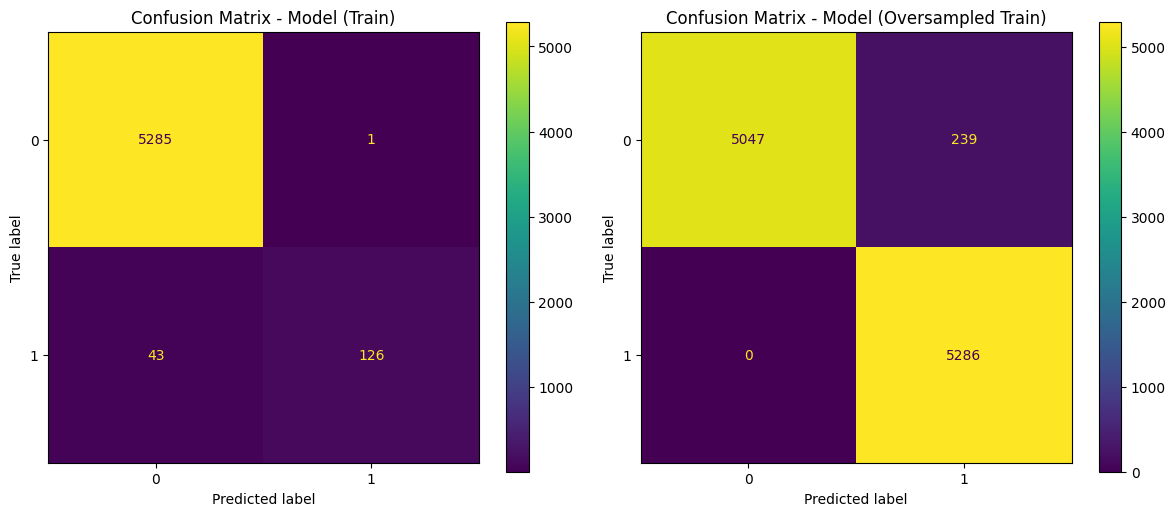

In [46]:
# Plot confusion matrix
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # Create subplots for side-by-side plots

# Plot confusion matrix for the first model (on train data)
ConfusionMatrixDisplay.from_estimator(model_reg, X_train, y_train, ax=axes[0])
axes[0].set_title('Confusion Matrix - Model (Train)')

# Plot confusion matrix for the second model (on oversampled train data)
ConfusionMatrixDisplay.from_estimator(model_over, X_train_over, y_train_over, ax=axes[1])
axes[1].set_title('Confusion Matrix - Model (Oversampled Train)')

# Adjust layout to make sure plots don't overlap
plt.tight_layout()

# Show the plot
plt.show()

In [25]:
clf = GradientBoostingClassifier(random_state=42)

In [26]:
cv_scores = cross_val_score(clf,X_train_over,y_train_over,cv=5,n_jobs=-1)
print(cv_scores)

[0.9678487  0.97446809 0.97114475 0.97114475 0.97019868]


In [47]:
params = {'n_estimators': range(20,31,5)
        ,'max_depth': range(2,5)}

In [49]:
model = GridSearchCV(clf,param_grid=params,cv=5,n_jobs=-1,verbose=1)

In [50]:
model.fit(X_train_over,y_train_over)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': range(2, 5),
                         'n_estimators': range(20, 31, 5)},
             verbose=1)

In [51]:
model.best_estimator_

GradientBoostingClassifier(max_depth=4, n_estimators=30, random_state=42)

# Communicate

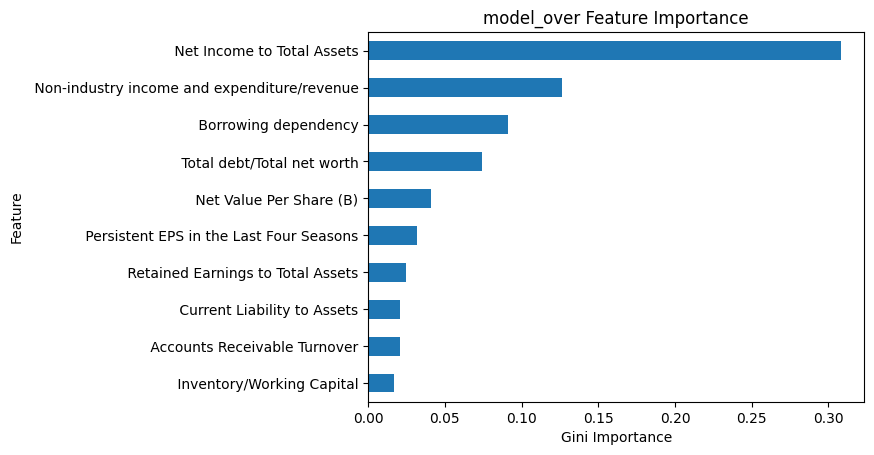

In [52]:
impfeature= pd.Series(model.best_estimator_.feature_importances_,index=X_test.columns).sort_values()
impfeature.tail(10).plot(kind='barh')
plt.xlabel("Gini Importance")
plt.ylabel("Feature")
plt.title("model_over Feature Importance");

In [55]:
# Save your model as bankrupt_model.pkl`
with open("bankrupt_model",'wb') as f :
    pickle.dump(model_over,f)

In [64]:
def wrangle(filepath):
    df=pd.read_csv(filepath)
    df.index.name ='id'
    df.rename(columns={'Bankrupt?': 'bankrupt'}, inplace=True)
    return df

In [65]:
def make_predictions(data_filepath, model_filepath):

    X_test = wrangle(data_filepath)
    # Load model
    with open(model_filepath,"rb") as f :
        model = pickle.load(f)
    # Generate predictions
    y_test_pred = model.predict(X_test)
    # Put predictions into Series with name "bankrupt", and same index as X_test
    y_test_pred = pd.Series(y_test_pred,X_test,named = "bankrupt")
    return y_test_pred

In [ ]:
y_test_pred = make_predictions(
    data_filepath="/content/data .csv",
    model_filepath="bankrupt_model",
)

print("predictions shape:", y_test_pred.shape)
y_test_pred.head()